Dependencies


In [174]:
import base64
import struct
from cobs import cobs
from collections import namedtuple
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
from scipy.signal import butter, filtfilt
import re 

Data

In [234]:
DataPacketDesc = {'type': 'B',
                  'size': 'B',
                  'crc16': 'H',
                  'packetID': 'I',
                  'us_start': 'I',
                  'us_end': 'I',
                  'analog': '8H',
                  'states': '8l',
                  'digitalIn': 'H',
                  'digitalOut': 'B',
                  'padding': 'x'}

DataPacket = namedtuple('DataPacket', DataPacketDesc.keys())
DataPacketStruct = '<' + ''.join(DataPacketDesc.values())
DataPacketSize = struct.calcsize(DataPacketStruct)

dtype_no_digital = [
    ('type', np.uint8),
    ('size', np.uint8),
    ('crc16', np.uint16),
    ('packetID', np.uint32),
    ('us_start', np.uint32),
    ('us_end', np.uint32),
    ('analog', np.uint16, (8, )),
    ('states', np.int32, (8, ))]
dtype_w_digital = dtype_no_digital + [('digital_in', np.uint8, (16, )), ('digital_out', np.uint8, (8, ))]

np_DataPacketType_noDigital = np.dtype(dtype_no_digital)
np_DataPacketType_withDigital = np.dtype(dtype_w_digital)

Methods

In [235]:
#read data in

def count_lines(fp):
    def _make_gen(reader):
        b = reader(2**16)
        while b:
            yield b
            b = reader(2**16)
    with open(fp, 'rb') as f:
        count = sum(buf.count(b'\n') for buf in _make_gen(f.raw.read))
    return count

In [236]:
def unpack_data_packet(dp):
    s = struct.unpack(DataPacketStruct, dp)
    up = DataPacket(type=s[0], size=s[1], crc16=s[2], packetID=s[3], us_start=s[4], us_end=s[5],
                    analog=s[6:14], states=s[14:22], digitalIn=s[22], digitalOut=s[23], padding=None)
    return up

In [34]:
#simple filters
import copy
def threshold_filter(data, lower, upper, default):
    filtered_data = np.zeros_like(data)
    for i in range(len(filtered_data)):
        if data[i]>lower and data[i]<upper:
            filtered_data[i] = default
    return filtered_data        

def threshold_filter2(data, threshold, val):
    return (data < threshold).astype(np.float32) * val
        
#upper=max(data)*0.8  sets threshold to 80% of the maximal value
#in the same way with lower and min
#whatever is larger than lower and smaller than upper is set to the default
# filter = threshold_filter2(data['analog'][start:end, 4],2000)
# plt.plot(filter) 
# filter = threshold_filter(data['analog'][start:end, 4],1600,2000,2400)
# plt.plot(filter)


In [35]:
#bandpass filter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y



In [36]:
#calculate psth


def count_bin(data,index,bin_start, bin_end):
    start = max(0,index + bin_start)
    stop = min(len(data),index + bin_end)
    return sum(data[start:stop])

def average_bin_count(triggers,data,bin_start,bin_end):
    count = 0
    indices = np.where(triggers == 1)[0]
    for index in indices:
        count  = count + count_bin(data,index,bin_start,bin_end)
    return count/len(indices)

def histogram_data(triggers,data,bins):
    bin_counts = []
    for current_bin in bins:
        bin_counts.append(average_bin_count(triggers,data,current_bin[0],current_bin[1]))
    return bin_counts

In [171]:
def get_time(string):
    pattern = re.compile("[0-9]{2}:[0-9]{2}:[0-9]{2}") # Abstract form of time stamps using regular expressions.
    pos = pattern.search(string) # Find the locations of the pattern in the string.
    
    # Timestamps have the form hh:mm:ss
    hrs = string[pos.start():pos.start()+2] 
    mins = string[pos.start()+3:pos.start()+5]
    secs = string[pos.start()+6:pos.start()+8]
    hrs
    # Return the hours, minutes and seconds, converted to numbers (here integers)
    return [int(hrs)*3600 + int(mins)*60 + int(secs)]



Analysis

In [237]:
bp = Path('2021_08_21_m400061/20210821-212840_766.b64')
bp

PosixPath('2021_08_21_m400061/20210821-212840_766.b64')

In [238]:
num_lines = count_lines(bp)
log_duration = num_lines/1000/60
print(f'{num_lines} packets, ~{log_duration:0.2f} minutes')

3753750 packets, ~62.56 minutes


In [239]:
data = np.zeros(num_lines, dtype=np_DataPacketType_withDigital)
non_digital_names = list(np_DataPacketType_noDigital.names)

with open(bp, 'rb') as bf:
    for nline, line in enumerate(tqdm(bf, total=num_lines)):
        bl = cobs.decode(base64.b64decode(line[:-1])[:-1])
        dp = unpack_data_packet(bl)

        data[non_digital_names][nline] = np.frombuffer(bl[:-4], dtype=np_DataPacketType_noDigital)
        digital_arr = np.frombuffer(bl[-4:], dtype=np.uint8)
        data[nline]['digital_in'] = np.hstack([np.unpackbits(digital_arr[0]), np.unpackbits(digital_arr[1])])
        data[nline]['digital_out'] = np.unpackbits(np.array(digital_arr[2], dtype=np.uint8))

100%|██████████| 3753750/3753750 [02:01<00:00, 30804.69it/s]


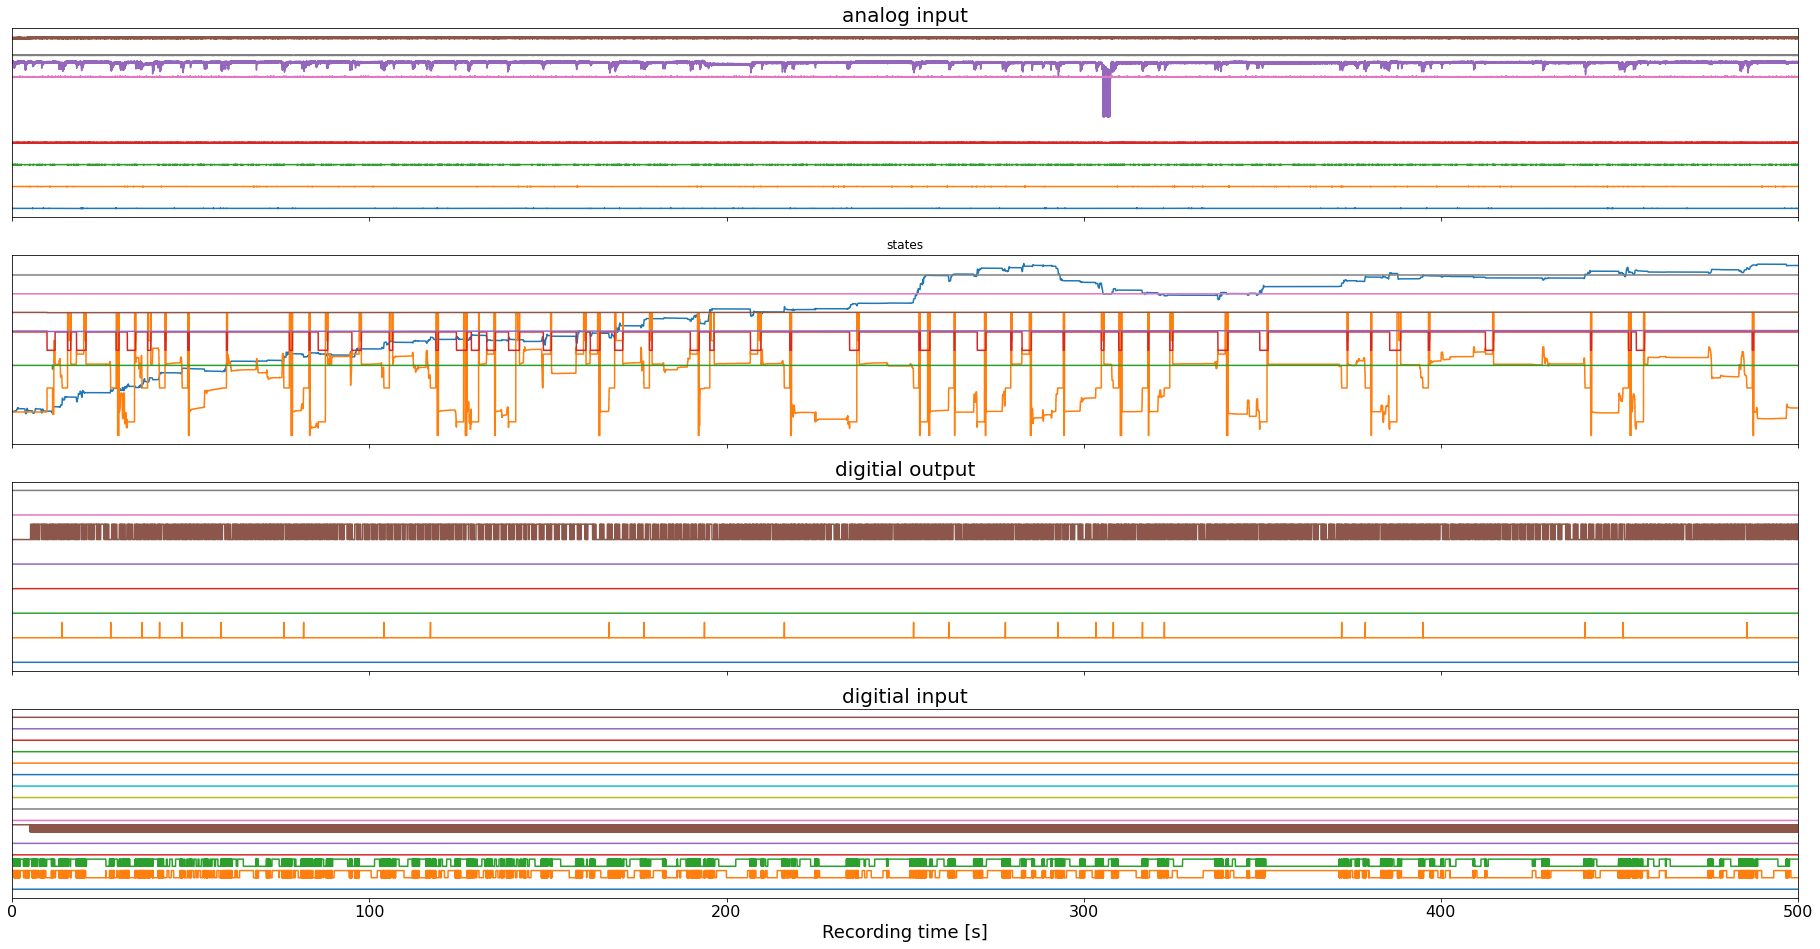

In [240]:
fig, ax = plt.subplots(4, figsize=(32, 16), sharex=True)
start, end = 0, 500000
t = np.linspace(start/1000, end/1000, end-start)
for n in range(8):
    ax[0].plot(t, data['analog'][start:end, n]+n*1024)
    ax[0].set_title('analog input', fontsize=20)
    ax[0].tick_params(labelsize=16)
    ax[0].set_yticks([])
    
    
    ax[1].plot(t, data['states'][start:end, n]+n*1024)
    ax[1].title.set_text('states')
    ax[1].set_yticks([])
    
    ax[2].plot(t, data['digital_out'][start:end, n]+n*1.6)
    ax[2].set_title('digitial output', fontsize=20)
    ax[2].tick_params(labelsize=16)
    ax[2].set_yticks([])

for n in range(16):
    ax[3].plot(t, data['digital_in'][start:end, n]+n*1.6)
#     ax[1].set_xlim(start, end)
    ax[3].set_title('digitial input', fontsize=20)
    ax[3].tick_params(labelsize=16)
    ax[3].set_yticks([])
    ax[3].set_xlim(t[0], t[-1])
    

plt.xlabel('Recording time [s]', fontsize = 18)
plt.savefig("Output.png")    

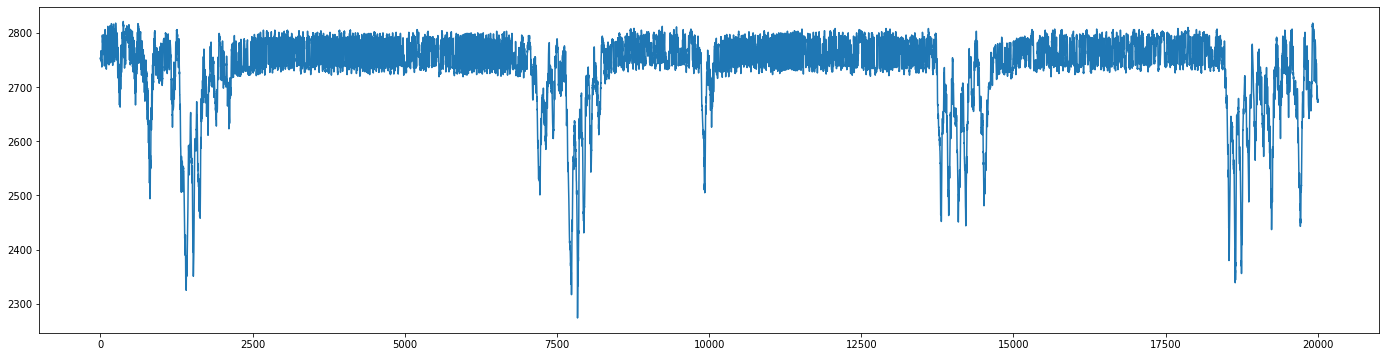

In [41]:
fig, ax = plt.subplots(1, figsize=(24, 6), sharex=True)
start, end = 40000, 60000
ax.plot(data['analog'][start:end, 4])

In [42]:
jumps = np.unique(np.diff(data['packetID']))
assert(len(jumps) and jumps[0] == 1)

In [43]:
t = np.linspace(0, 6000, 6000)
y = np.sin(t/5)

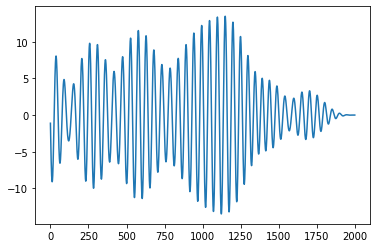

In [58]:
filter = butter_bandpass_filter(data['analog'][start:end, 4], 18, 22, 1000)
plt.plot(filter)


In [45]:
data.shape

(3753750,)

In [242]:
start, end = 20000, 60000
yf = butter_bandpass_filter(data['analog'][:, 4], 3, 25, 1000)[start:end]

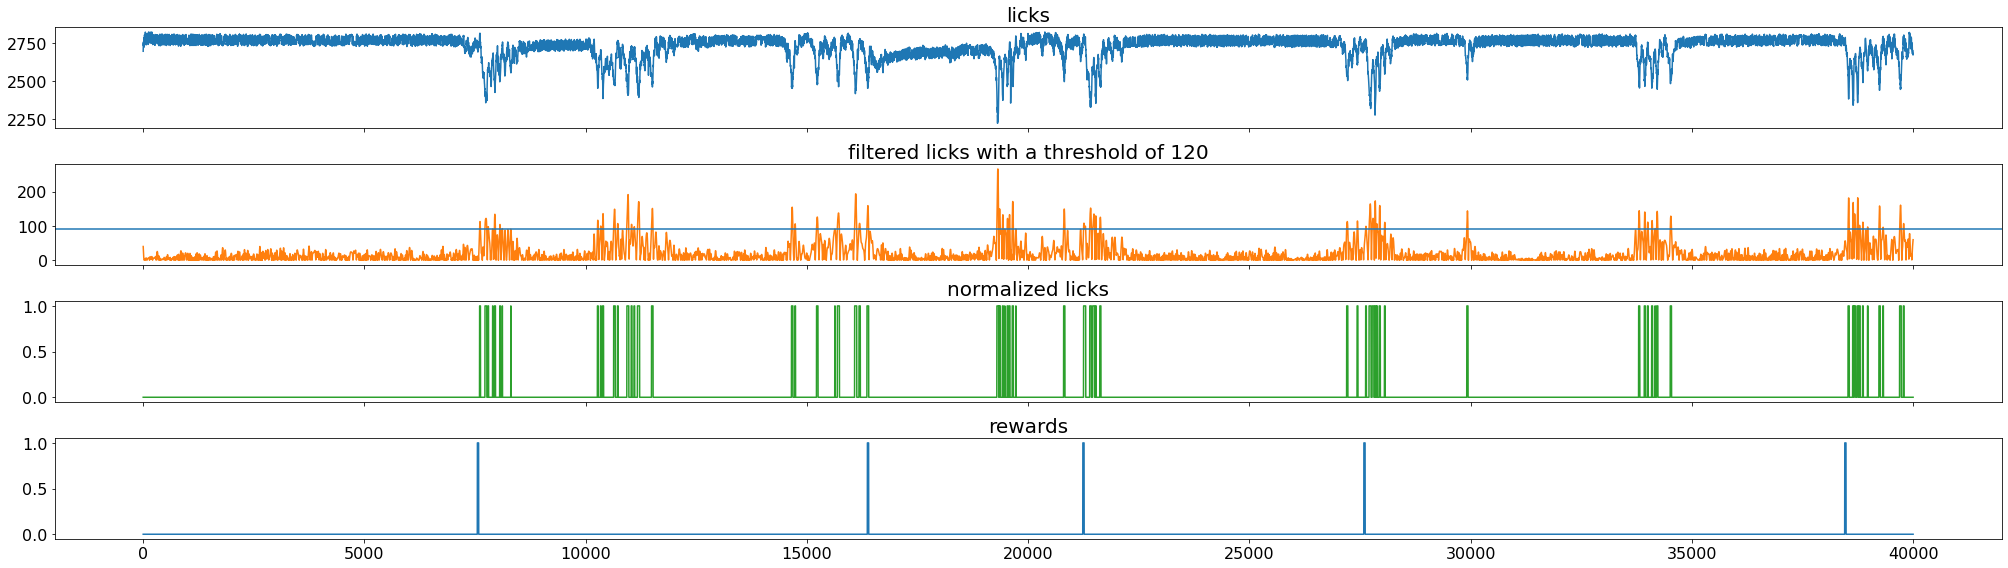

In [243]:
fig, ax = plt.subplots(4, figsize=(28, 8), sharex=True)
ax[0].plot(data['analog'][start:end,4])
ax[0].set_title('licks', fontsize=20)
ax[0].tick_params(labelsize=16)

ax[1].plot(np.abs(yf), c='C1')
ax[1].axhline(90)
ax[1].set_title('filtered licks with a threshold of 120', fontsize=20)
ax[1].tick_params(labelsize=16)

ax[2].plot(np.abs(yf) > 90, c='C2')
ax[2].set_title('normalized licks', fontsize=20)
ax[2].tick_params(labelsize=16)


ax[3].plot(data['digital_out'][start:end, 1])
ax[3].set_title('rewards', fontsize=20)
ax[3].tick_params(labelsize=16)

plt.tight_layout()
plt.savefig("lick_detection")

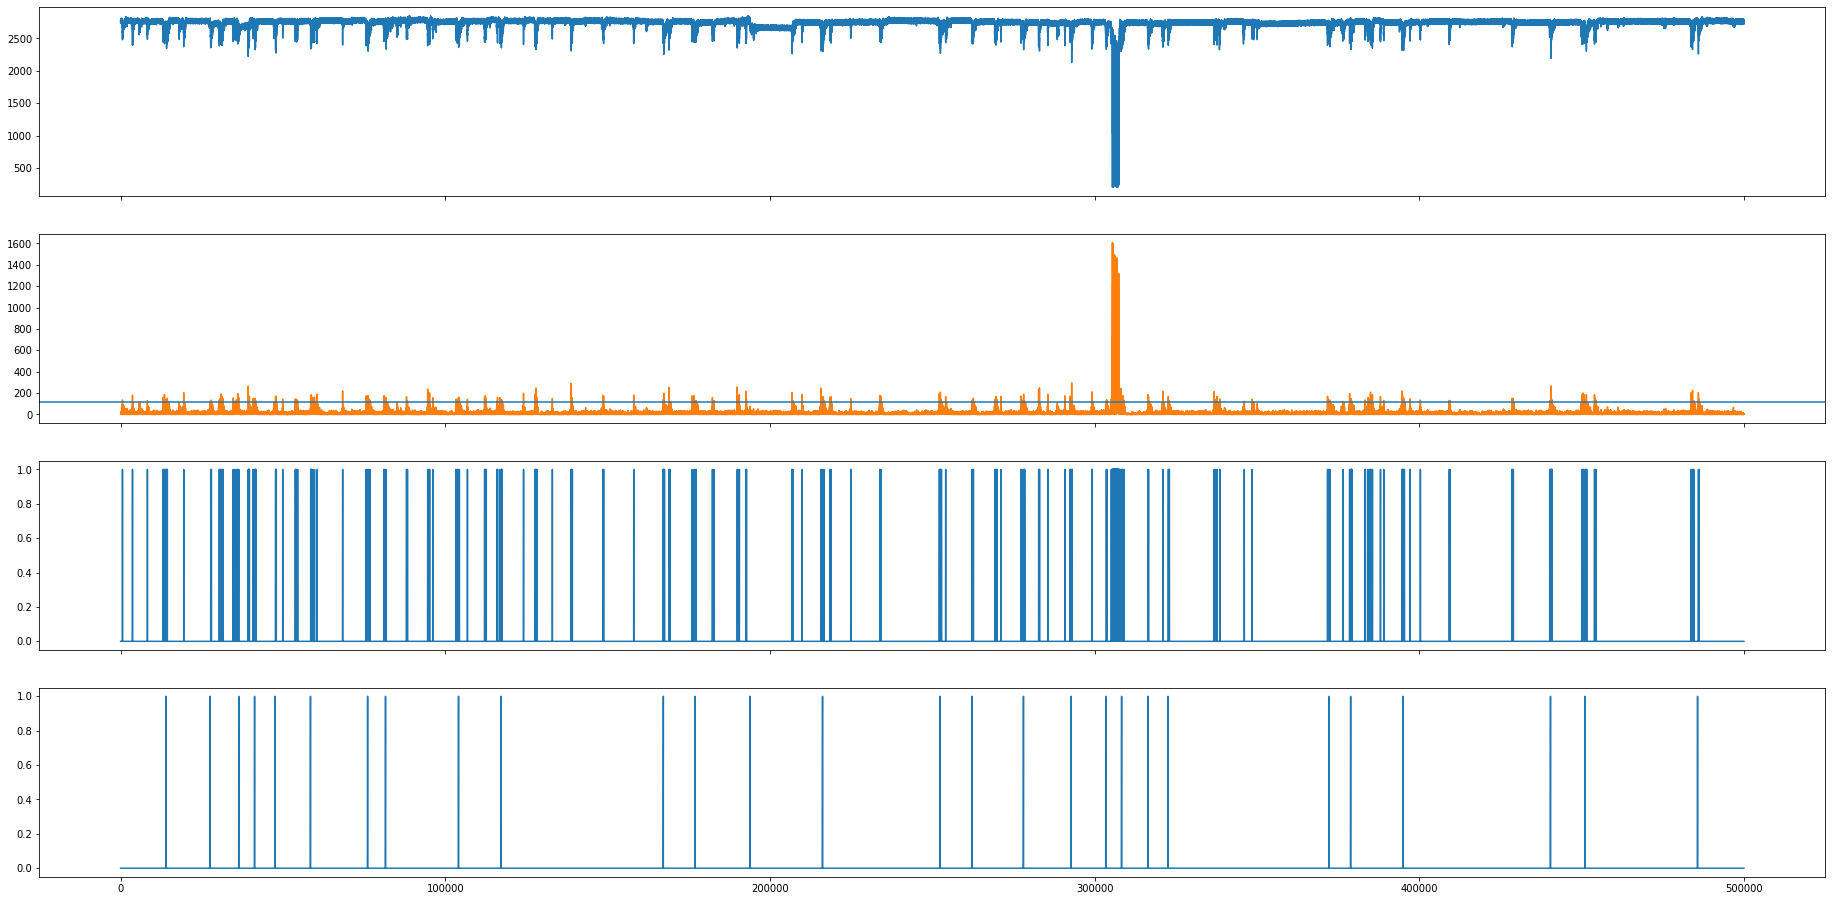

In [244]:

fig, ax = plt.subplots(4, figsize=(32, 16), sharex=True)
start, end = 0, 500000
spikes_unnormalized = butter_bandpass_filter(data['analog'][:, 4], 3, 25, 1000)
yf = butter_bandpass_filter(data['analog'][:, 4], 3, 25, 1000)[start:end]
ax[0].plot(data['analog'][start:end, 4])
ax[1].plot(np.abs(yf), c='C1')
ax[1].axhline(120)
ax[2].plot(np.abs(yf) > 120)
ax[3].plot(data['digital_out'][start:end, 1])



In [49]:
spikes=[]
for elm in spikes_unnormalized:
    if elm > 120:
        spikes.append(1)
    else:
        spikes.append(0)

spikes = np.array(spikes)
    
triggers= data['digital_out'][:, 1]

triggers = np.array(triggers)



In [76]:
np.where(triggers == 1)

(array([  13945,   13946,   13947, ..., 3710615, 3710616, 3710617]),)

In [89]:
bins = [(100*i,100*i+100) for i in range(-10,10)]
bins_plot = [(bin[1]-bin[0])/2 + bin[0] for bin in bins]
bin_counts = histogram_data(triggers,spikes,bins)

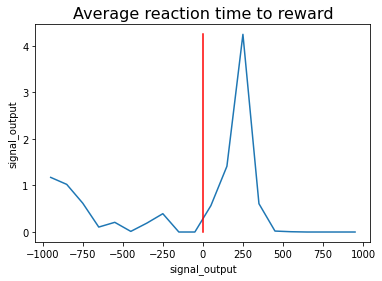

In [90]:
plt.plot(bins_plot,bin_counts)
plt.plot([0,0],[0,max(bin_counts)], color = "red")
plt.title('Average reaction time to reward', fontsize=16)
plt.ylabel('signal_output')
plt.xlabel('signal_output')
plt.savefig('reaction time')


In [245]:
led_trace_path = next(bp.parent.glob('*.yuv'))

In [246]:
trace = np.fromfile(led_trace_path.with_suffix('.yuv'), np.uint8)

(-12.0, 54.0)

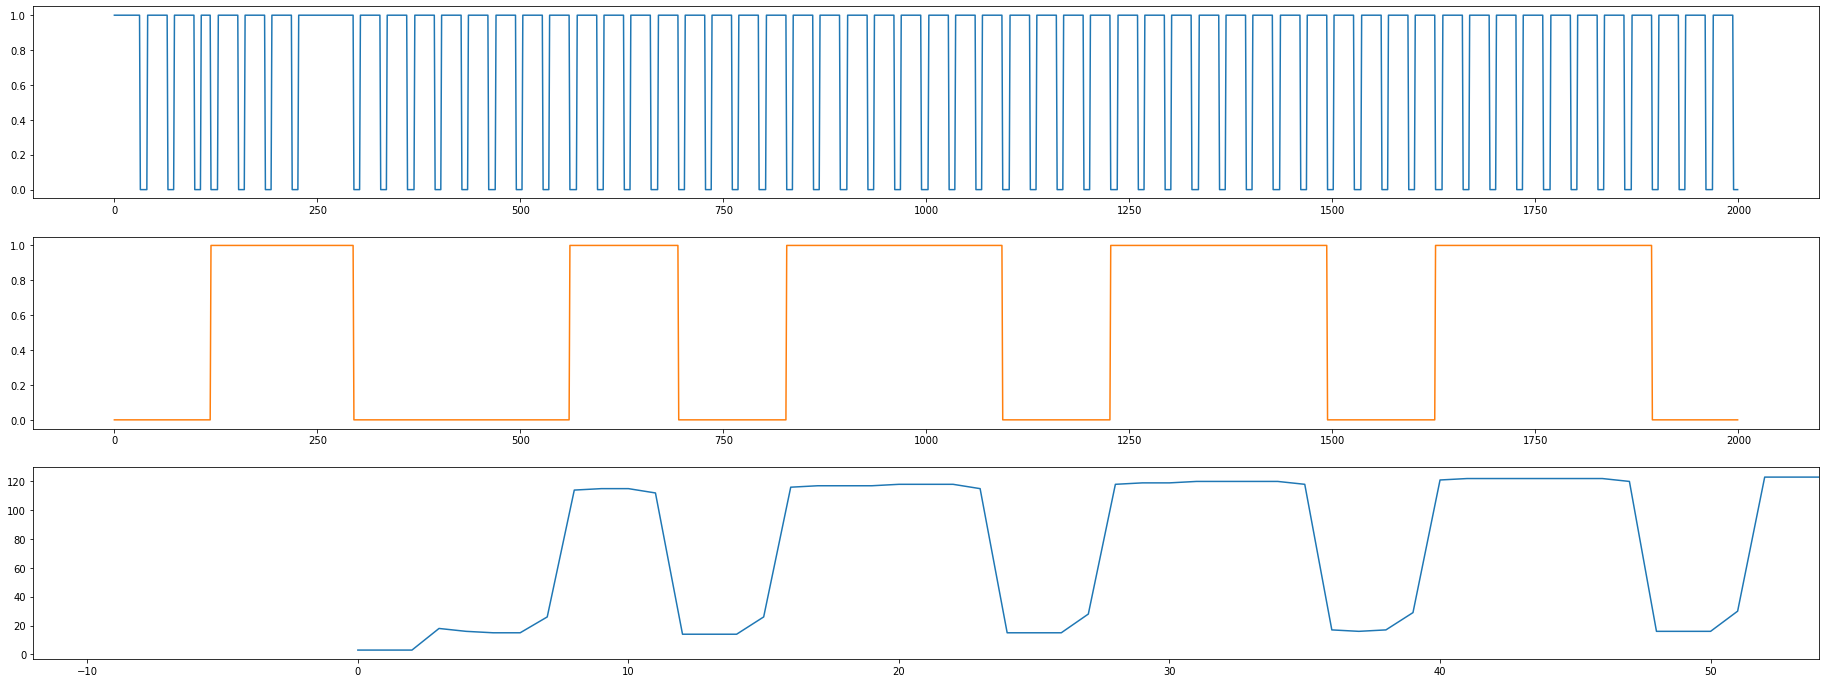

In [247]:
fig, ax = plt.subplots(3, figsize=(32, 12))
start, end = 5000, 7000
ax[0].plot(data['digital_in'][start:end, 5])
ax[1].plot(data['digital_out'][start:end, 5], c='C1')

ax[2].plot(trace[:68])
ax[2].set_xlim(-12, 54)

In [56]:
df = pd.read_csv("commanderCam_2021-Aug-13_16-53-33_EYEDLC_resnet50_pupil_metricAug20shuffle1_460000.csv", header=2)
# df = pd.read_csv("C:/Users/reichler/data/Neurofeedback/2021_08_21/m400061/eyeDLC_resnet50_pupil_metricAug20shuffle1_460000.csv", header=2)
new_names = ['frame'] + [f'{cn}{n}' for n in range(8) for cn in ['x', 'y', 'l']]
df.rename(columns=dict(zip(df.columns, new_names)), inplace=True)
X = df.iloc[:, 1::3].values
Y = df.iloc[:, 2::3].values
DP = (X[:, :4] - X[:, 4:])**2 + (Y[:, :4] - Y[:, 4:])**2
D = np.mean(np.sqrt(DP), axis=1)

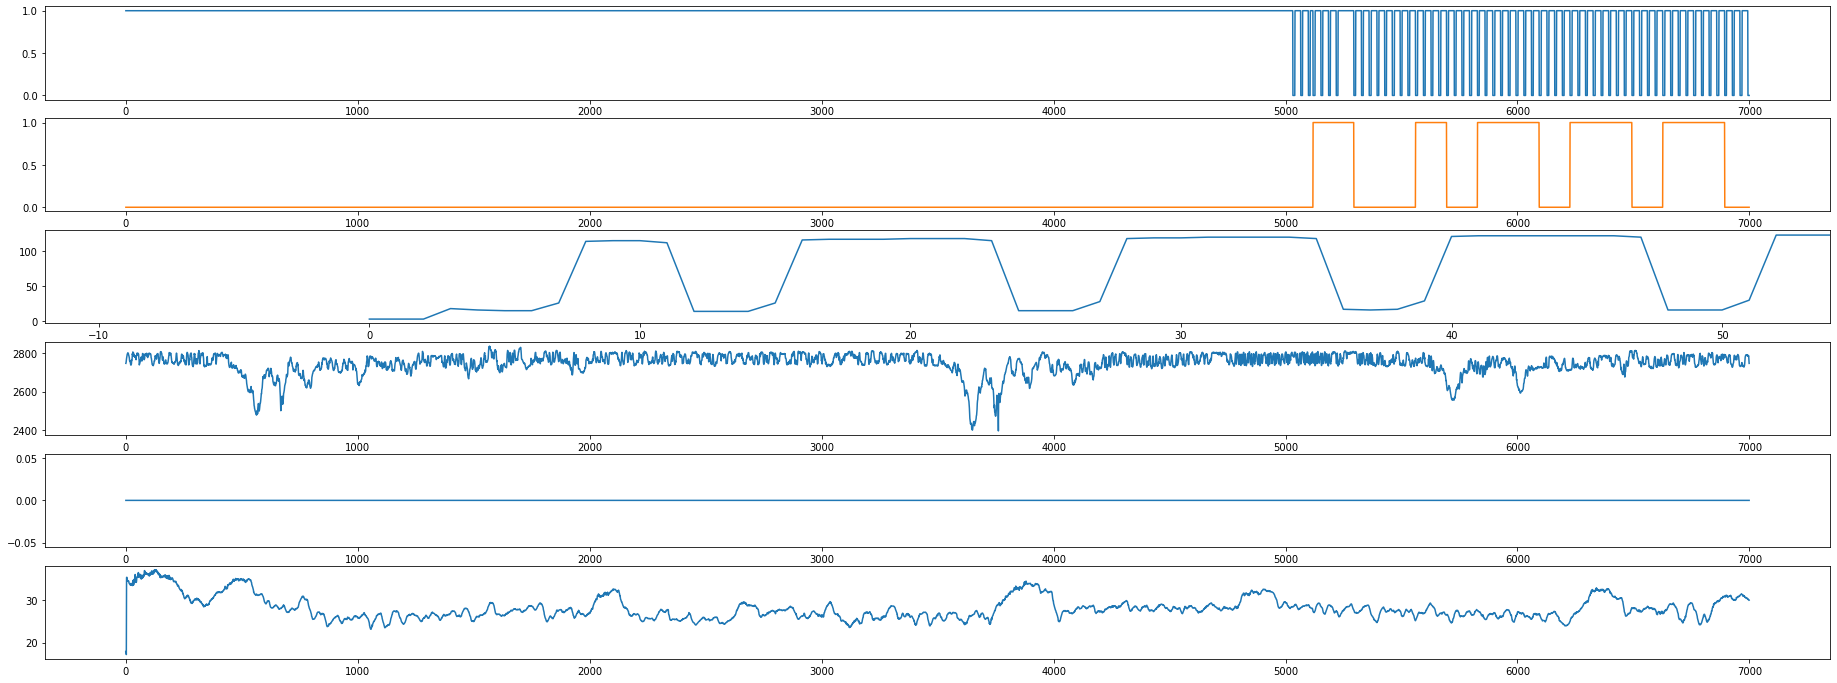

In [123]:
fig, ax = plt.subplots(6, figsize=(32, 12))
start, end = 0, 7000
ax[0].plot(data['digital_in'][start:end, 5])
ax[1].plot(data['digital_out'][start:end, 5], c='C1')

ax[2].plot(trace[:68])
ax[2].set_xlim(-12, 54)

ax[3].plot(data['analog'][start:end, 4])

ax[4].plot(data['digital_out'][start:end, 1])

ax[5].plot(D[start:end])






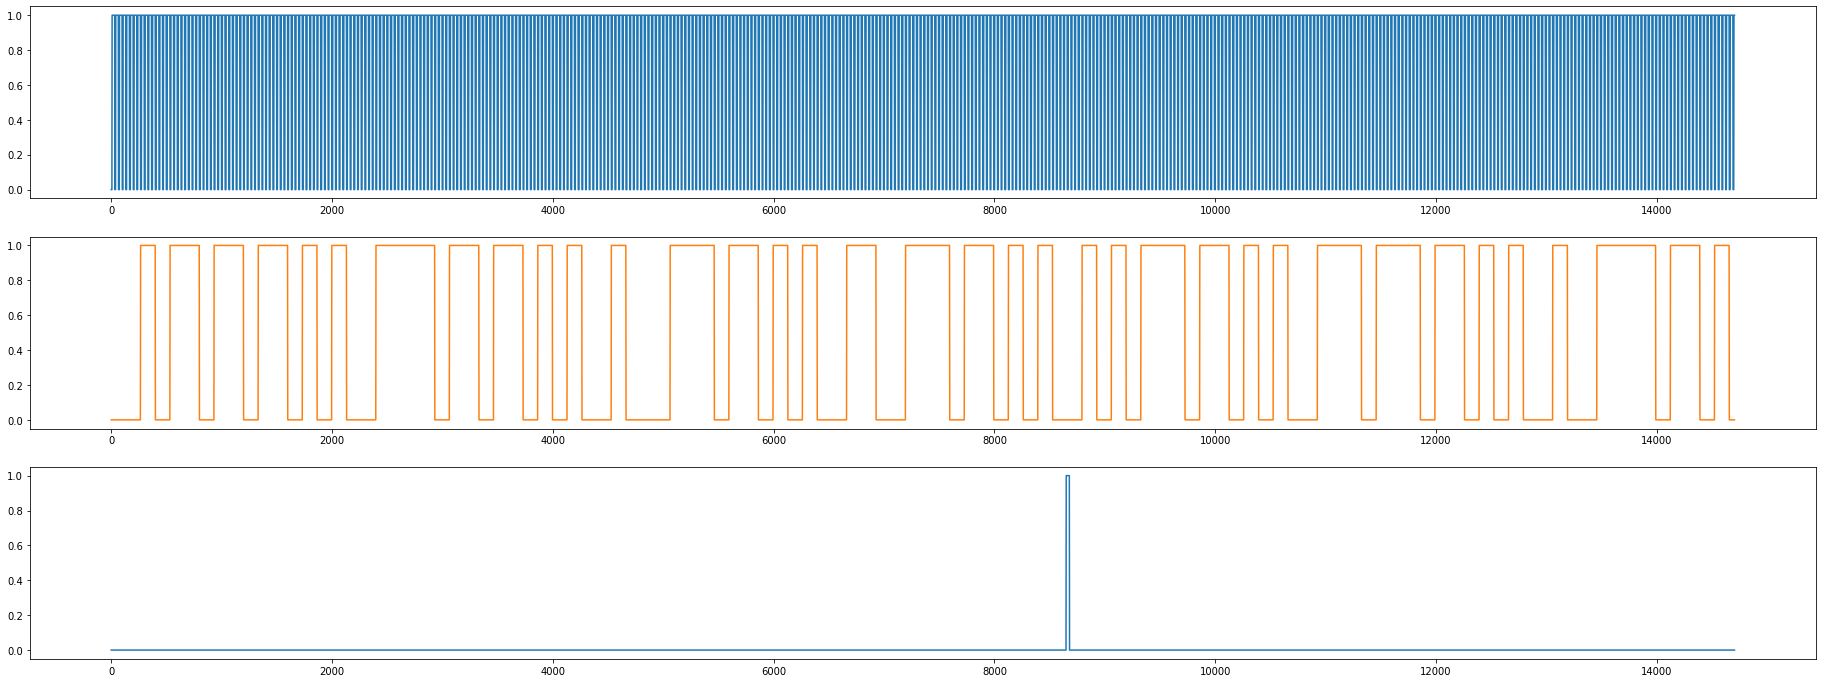

In [114]:
fig, ax = plt.subplots(3, figsize=(32, 12))
start, end = 5296, 20000
ax[0].plot(data['digital_in'][start:end, 5])
ax[1].plot(data['digital_out'][start:end, 5], c='C1')
ax[2].plot(data['digital_out'][start:end, 1])


In [118]:
fast_pulses=data['digital_in'][5296:-1, 5]
slow_pulses=data['digital_out'][5296:-1, 5]
rewards=data['digital_out'][5296:-1, 1]



In [110]:
data['digital_in'][5290:5300, 5]


array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0], dtype=uint8)

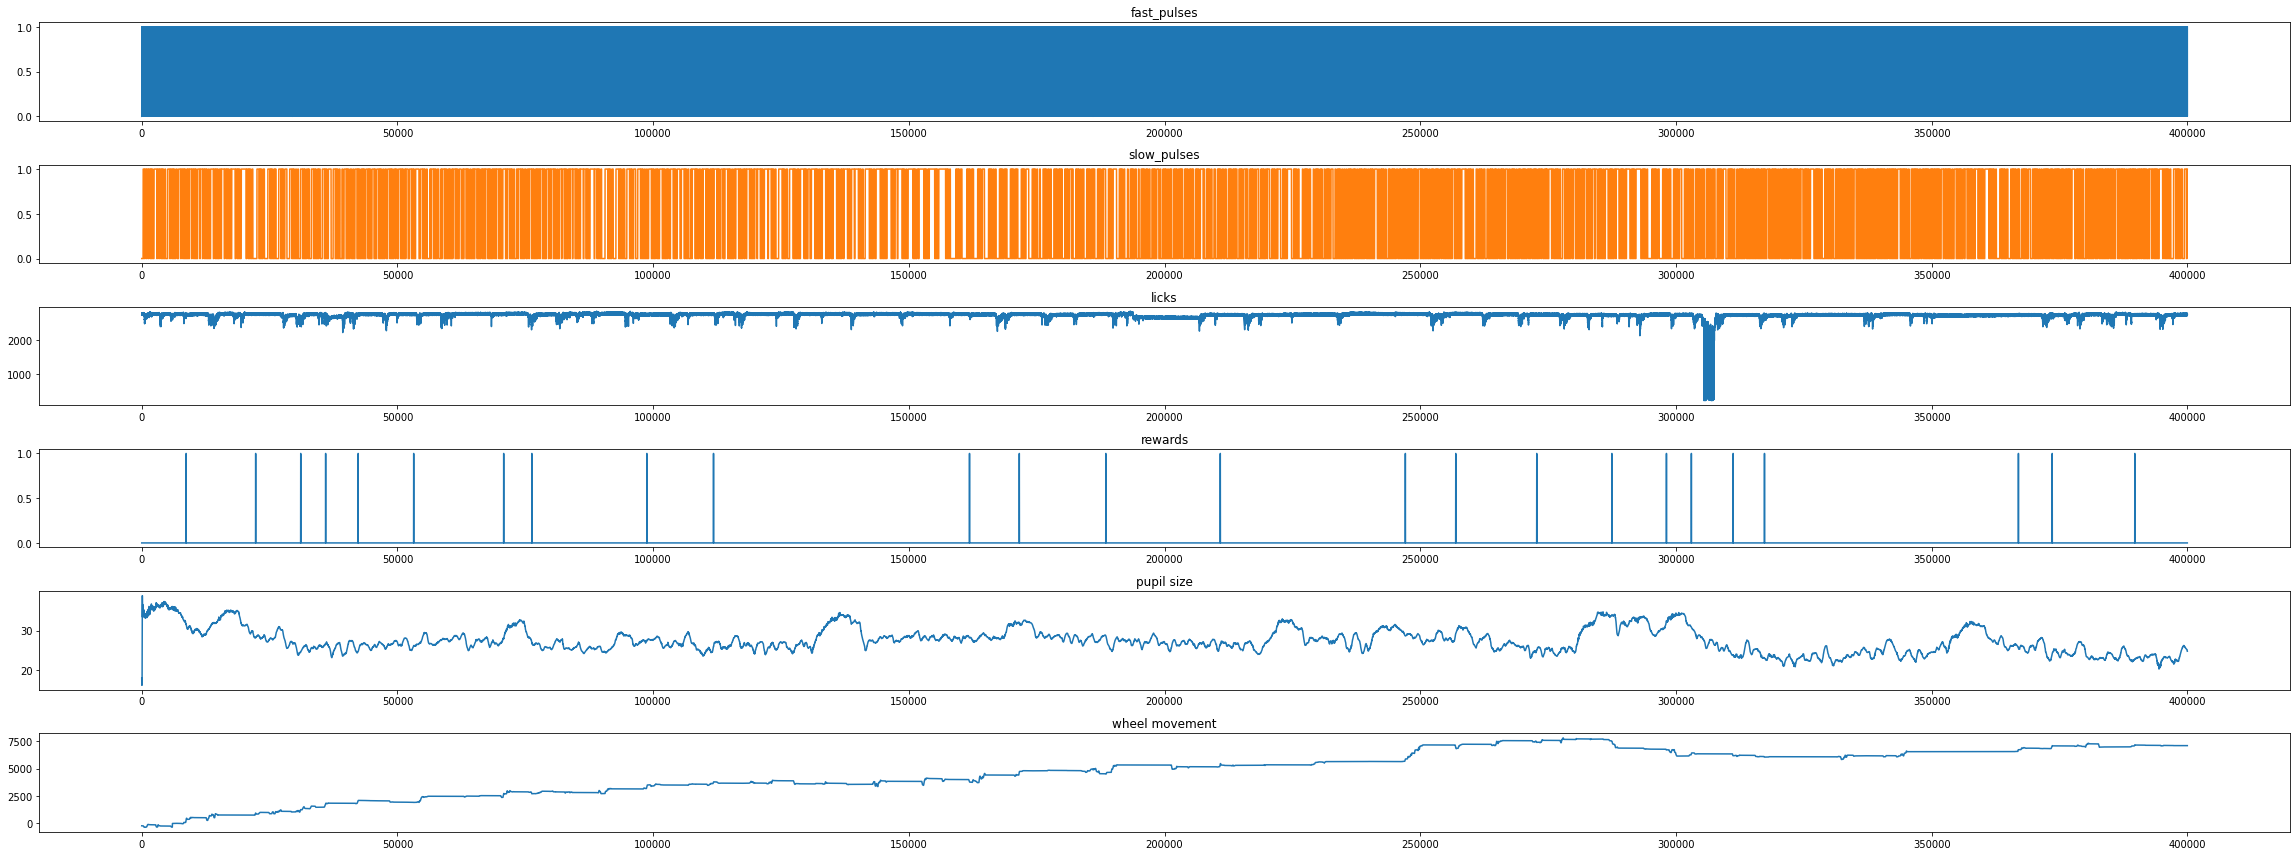

In [260]:
fig, ax = plt.subplots(6, figsize=(32, 12))
start, end = 0, 400000
ax[0].plot(fast_pulses[start:end])
ax[0].set_title("fast_pulses")
ax[1].plot(slow_pulses[start:end], c='C1')
ax[1].set_title("slow_pulses")



ax[2].plot(data['analog'][start:end, 4])
ax[2].set_title("licks")

ax[3].plot(rewards[start:end])
ax[3].set_title("rewards")

ax[4].plot(resampled_pupil[start:end])
ax[4].set_title("pupil size")
ax[5].plot(wheel[start:end])
ax[5].set_title("wheel movement")

plt.tight_layout()


In [258]:
wheel=data['states'][5296:-1, 0]

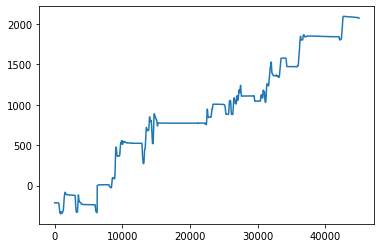

In [259]:
plt.plot(data['states'][5000:50000, 0])

In [133]:
len(fast_pulses)

3748453

In [134]:
len(D)

106559

In [251]:
resampled_pupil = scipy.signal.resample(D,len(fast_pulses))

In [252]:
len(resampled_pupil)

3748453

In [263]:
wheel_left = []
wheel_right = []
# The with statement will automatically close the file after the operations.
with open("NF_group1/m400060/2021_08_09/20210809-160016_game.log","r") as current_file:
    for line in current_file.readlines():
        if "from the left" in line: 
            wheel_left.append(line)
        elif "from the right" in line:
            wheel_right.append(line)
        
    
 # Show the list:
wheel_left

['[16:00:20]{training.py:75} INFO - Starting trial 1 from the left with             0.3 s delay\n',
 '[16:00:26]{training.py:75} INFO - Starting trial 2 from the left with             0.0 s delay\n',
 '[16:00:28]{training.py:75} INFO - Starting trial 3 from the left with             0.2 s delay\n',
 '[16:00:45]{training.py:75} INFO - Starting trial 4 from the left with             0.2 s delay\n',
 '[16:00:50]{training.py:75} INFO - Starting trial 5 from the left with             0.3 s delay\n',
 '[16:00:58]{training.py:75} INFO - Starting trial 6 from the left with             0.3 s delay\n',
 '[16:01:25]{training.py:75} INFO - Starting trial 7 from the left with             0.1 s delay\n',
 '[16:01:27]{training.py:75} INFO - Starting trial 8 from the left with             0.1 s delay\n',
 '[16:01:29]{training.py:75} INFO - Starting trial 9 from the left with             0.3 s delay\n',
 '[16:01:38]{training.py:75} INFO - Starting trial 10 from the left with             0.2 s delay\n',

In [264]:
times_left = []
times_right = []
for i in wheel_left:
    times_left.append(get_time(i))
    
for i in wheel_right:
    times_right.append(get_time(i))    
times_left[:] 
times_left[-1]

[61336]

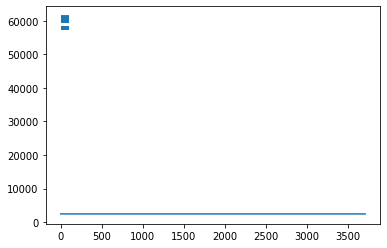

In [255]:
plt.plot(wheel[57620:61336])
plt.hlines(times_left[1], 0, 100)

for i in times_left:
    plt.hlines(i, 0,100)

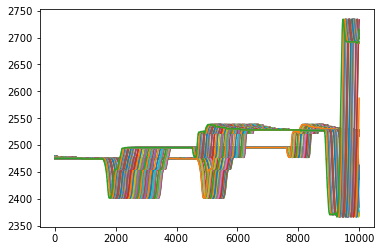

In [261]:
for i in times_left:
    plt.plot(wheel[i[0]:i[0]+10000])


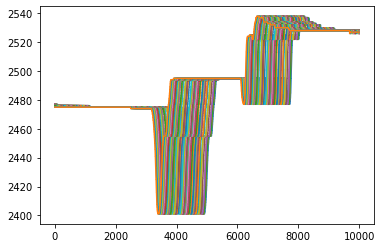

In [262]:
for i in times_right:
    plt.plot(wheel[i[0]:i[0]+10000])
   
    